# Satellite and Solar Angles

<hr>

## Satellite-Zenith Angle

The satellite-viewing angle (or satellite-zenith angle) is proportional to the pixel area for a geostationary satellite. As this angle increases, the pixel area increases. In the figure below, the satellite-zenith angle is the angle between an observer's zenith (looking straight up) and the line connecting the observer and the satellite [image credit: Royal Belgian Institute for Space Aeronomy].

<img src="https://github.com/jlc248/satellite-resources/blob/main/docs/_static/images/vza-sza.gif?raw=true">

This could be helpful to calculate, as one may wish to characterize some research analysis as a function of satellite-zenith angle, to discriminate between "near-nadir" locations, "limb" locations, and those in-between.

The "limb" is the term generally referred to as those locations on the extremeties of the satellite field of view. For geostationary satellites, the "limb" is generally satellite-zenith angle ≥ 85 degrees

### Install libraries

In [63]:
!pip -q install cartopy
!pip -q install netCDF4
!pip -q install s3fs

### Download GOES-16 ABI L1b file

In [15]:
import s3fs
import datetime

fs = s3fs.S3FileSystem(anon=True) #connect to s3 bucket!

abidt = datetime.datetime(2024,8,13,18,40)

file_location = fs.glob(abidt.strftime('s3://noaa-goes16/ABI-L1b-RadF/%Y/%j/%H/*C13*_s%Y%j%H%M*.nc'))
_ = fs.download(file_location[0], 'test.nc')

Here is the code to compute the satellite-zenith angle. In requires latitudes, longitudes, and the satellite positional longitude (`satlon`, default = -75.0).

In [16]:
import numpy as np

def sat_zen_angle(xlat, xlon, satlat=0, satlon=-75.0):

    """
    Calculate the satellite-zenith or satellite-viewing angle
    of given geographical coordinates given the position of a geostationary satellite.

    Args:
      xlat: Numpy array (or list) of latitude coordinates.
      xlon: Numpy array (or list) of longitude coordinates.
      satlat: Satellite latitude, default 0.
      satlon: Satellite longitude, default -75.0.

    Returns:
      Numpy array of satellite zenith angles.

    """

    DTOR = np.pi / 180.0

    if isinstance(xlat, list):
        xlat = np.array(xlat)
    if isinstance(xlon, list):
        xlon = np.array(xlon)

    lon = (xlon - satlon) * DTOR
    lat = (xlat - satlat) * DTOR

    beta = np.arccos(np.cos(lat) * np.cos(lon))
    sin_beta = np.sin(beta)

    zenith = np.arcsin(
        42164.0 * sin_beta / np.sqrt(1.808e09 - 5.3725e08 * np.cos(beta))
    )

    zenith = zenith / DTOR

    return zenith


### Compute the latitudes and longitudes

The function below will compute latitudes and longitudes for a GOES-R file, which has a fixed-grid format.

In [19]:
def calculate_abi_degrees(file_id):

    """
    Calculate latitude and longitude from GOES ABI fixed grid projection data
    GOES ABI fixed grid projection is a map projection relative to the GOES satellit
    Units: latitude in °N (°S < 0), longitude in °E (°W < 0)
    See GOES-R Product User Guide (PUG) Volume 5 (L2 products) Section 4.2.8 for details & example of calculation
    "file_id" is an ABI L1b or L2 .nc file opened using the netCDF4 library
    This function was created by NOAA/NESDIS/STAR Aerosols and Atmospheric Composition Science Team.
    """

    # Read in GOES ABI fixed grid projection variables and constants
    x_coordinate_1d = file_id.variables['x'][:]  # E/W scanning angle in radians
    y_coordinate_1d = file_id.variables['y'][:]  # N/S elevation angle in radians
    projection_info = file_id.variables['goes_imager_projection']
    lon_origin = projection_info.longitude_of_projection_origin
    H = projection_info.perspective_point_height+projection_info.semi_major_axis
    r_eq = projection_info.semi_major_axis
    r_pol = projection_info.semi_minor_axis

    # Create 2D coordinate matrices from 1D coordinate vectors
    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)

    # Equations to calculate latitude and longitude
    lambda_0 = (lon_origin*np.pi)/180.0
    a_var = np.power(np.sin(x_coordinate_2d),2.0) + (np.power(np.cos(x_coordinate_2d),2.0)*(np.power(np.cos(y_coordinate_2d),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(y_coordinate_2d),2.0))))
    b_var = -2.0*H*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    c_var = (H**2.0)-(r_eq**2.0)
    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
    s_x = r_s*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    s_y = - r_s*np.sin(x_coordinate_2d)
    s_z = r_s*np.cos(x_coordinate_2d)*np.sin(y_coordinate_2d)

    # Ignore numpy errors for sqrt of negative number; occurs for GOES-16 ABI CONUS sector data
    np.seterr(all='ignore')

    abi_lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    abi_lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)

    return abi_lat, abi_lon

### Compute and visualize satellite-zenith angle

In [42]:
# Open the ABI L1b file

from netCDF4 import Dataset
nc = Dataset('test.nc', 'r')
lats, lons = calculate_abi_degrees(nc)
# Get projection coords for plotting
projx = nc.variables['x'][:] * nc.variables['goes_imager_projection'].perspective_point_height
projy = nc.variables['y'][:] * nc.variables['goes_imager_projection'].perspective_point_height
nc.close()

# Compute SZA

sza = sat_zen_angle(xlon=lons, xlat=lats, satlon=-75)

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


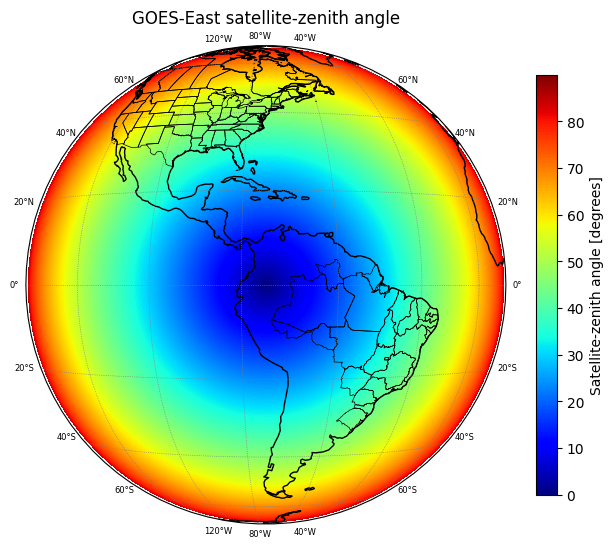

In [62]:
# Visualize

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline

state_borders = cfeature.STATES.with_scale("50m")

crs = ccrs.Geostationary(central_longitude=-75.0)

fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0,0,1,1], projection=crs)
extent = [projx.min(), projx.max(), projy.min(), projy.max()]
im = ax.imshow(sza, cmap='jet', extent=extent, transform=crs)
ax.coastlines()
ax.add_feature(state_borders, edgecolor="black", linewidth=0.5)
plt.title('GOES-East satellite-zenith angle')

gl = ax.gridlines(
  crs=ccrs.PlateCarree(),
  draw_labels=True,
  linewidth=0.5,
  color="gray",
  linestyle=":",
)
# Customize the gridline labels
gl.xlocator = mticker.FixedLocator([-120, -100, -80, -60, -40, -20])
#gl.xformatter = LONGITUDE_FORMATTER
# only display given longitudes
gl.xformatter = plt.FuncFormatter(lambda x, pos: f'{np.abs(int(x))}°W' if x in [-120, -80, -40] else '')
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {"size": 6}
gl.ylabel_style = {"size": 6}

cbar = plt.colorbar(im, ax=ax, shrink=0.7)
cbar.set_label('Satellite-zenith angle [degrees]')

Now we can plainly see how satellite-zenith angle increases from 0 to 90 degrees from nadir to the limb, and increases very rapidly once SZA hits 60 degrees.

## Solar angles

The solar-zenith angle defines the Sun's apparent altitude to an observer on earth, relative to the observer's zenith (looking straight up).

The solar-azimuth angle is the azimuth (horizontal angle with respect to north) of the Sun's position. This horizontal coordinate defines the Sun's relative direction along the local horizon. Solar-azimuth angle is the compass direction from which the sunlight is coming from. North is 0 deg, east is 90 deg, south is 180 deg, and west is 270 deg.

Both angles are dependent only on location and the date-time. If you are doing an analysis between "night" and "day,", the solar-zenith angle may be useful. If you are doing an analysis conditioned on time-of-day, or rather, how far the sun has progressed during the day, then solar-azimuth angle might be helpful.

Below is the code to compute both angles:

In [64]:
import numpy as np


def solar_angles(dt, lon, lat):
    """
    ---------------------------------------------------------------------
    Compute solar angles

    Args:
        dt   = python datetime object
        lon  = latitude in degrees
        lat  = latitude in degrees

    Returns:
        asol = solar zenith angle in degrees
        phis = solar azimuth angle in degrees

    ----------------------------------------------------------------------
    """

    if not (isinstance(dt, list)) and not (isinstance(dt, np.ndarray)):
        dt = [dt]
    lon = np.array(lon)
    lat = np.array(lat)

    hour = np.array([_.hour for _ in dt])
    minute = np.array([_.minute for _ in dt])
    jday = np.array([int(_.strftime("%j")) for _ in dt])

    dtor = np.pi / 180.0

    tu = hour + minute / 60.0

    #      mean solar time
    tsm = tu + lon / 15.0
    xlo = lon * dtor
    xla = lat * dtor
    xj = np.copy(jday)

    #      time equation (mn.dec)
    a1 = (1.00554 * xj - 6.28306) * dtor
    a2 = (1.93946 * xj + 23.35089) * dtor
    et = -7.67825 * np.sin(a1) - 10.09176 * np.sin(a2)

    #      true solar time
    tsv = tsm + et / 60.0
    tsv = tsv - 12.0

    #      hour angle
    ah = tsv * 15.0 * dtor

    #      solar declination (in radian)
    a3 = (0.9683 * xj - 78.00878) * dtor
    delta = 23.4856 * np.sin(a3) * dtor

    #     elevation, azimuth
    cos_delta = np.cos(delta)
    sin_delta = np.sin(delta)
    cos_ah = np.cos(ah)
    sin_xla = np.sin(xla)
    cos_xla = np.cos(xla)

    amuzero = sin_xla * sin_delta + cos_xla * cos_delta * cos_ah
    elev = np.arcsin(amuzero)
    cos_elev = np.cos(elev)
    az = cos_delta * np.sin(ah) / cos_elev
    caz = (-cos_xla * sin_delta + sin_xla * cos_delta * cos_ah) / cos_elev
    azim = 0.0 * az
    index = np.where(az >= 1.0)
    if np.size(index) > 0:
        azim[index] = np.arcsin(1.0)
    index = np.where(az <= -1.0)
    if np.size(index) > 0:
        azim[index] = np.arcsin(-1.0)
    index = np.where((az > -1.0) & (az < 1.0))
    if np.size(index) > 0:
        azim[index] = np.arcsin(az[index])

    index = np.where(caz <= 0.0)
    if np.size(index) > 0:
        azim[index] = np.pi - azim[index]

    index = np.where((caz > 0.0) & (az <= 0.0))
    if np.size(index) > 0:
        azim[index] = 2 * np.pi + azim[index]
    azim = azim + np.pi
    pi2 = 2 * np.pi
    index = np.where(azim > pi2)
    if np.size(index) > 0:
        azim[index] = azim[index] - pi2

    #     conversion in degrees
    elev = elev / dtor
    asol = 90.0 - elev
    phis = azim / dtor
    sol_zenith = asol
    sol_azimuth = phis

    return sol_zenith, sol_azimuth

We will re-use the data we downloaded previously.

### Compute solar angles

In [66]:
solzen, solaz = solar_angles(abidt, lons, lats)

### Visualize solar angles

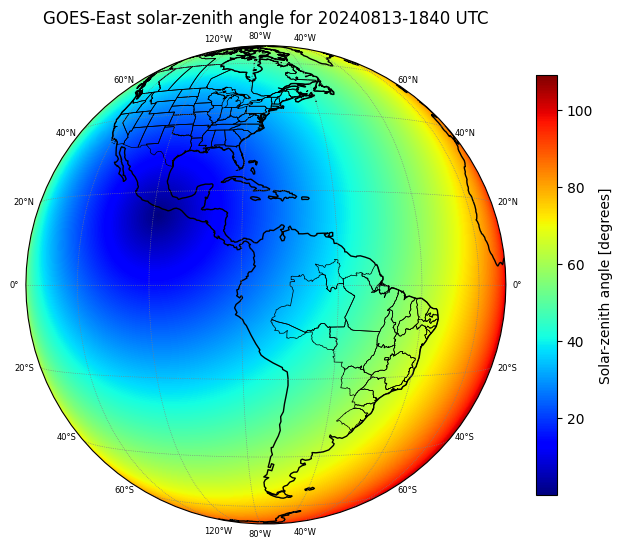

In [67]:
# Visualize

fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0,0,1,1], projection=crs)
extent = [projx.min(), projx.max(), projy.min(), projy.max()]
im = ax.imshow(solzen, cmap='jet', extent=extent, transform=crs)
ax.coastlines()
ax.add_feature(state_borders, edgecolor="black", linewidth=0.5)
plt.title(f'GOES-East solar-zenith angle for {abidt.strftime("%Y%m%d-%H%M UTC")}')

gl = ax.gridlines(
  crs=ccrs.PlateCarree(),
  draw_labels=True,
  linewidth=0.5,
  color="gray",
  linestyle=":",
)
# Customize the gridline labels
gl.xlocator = mticker.FixedLocator([-120, -100, -80, -60, -40, -20])
#gl.xformatter = LONGITUDE_FORMATTER
# only display given longitudes
gl.xformatter = plt.FuncFormatter(lambda x, pos: f'{np.abs(int(x))}°W' if x in [-120, -80, -40] else '')
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {"size": 6}
gl.ylabel_style = {"size": 6}

cbar = plt.colorbar(im, ax=ax, shrink=0.7)
cbar.set_label('Solar-zenith angle [degrees]')

Looking at the image above, for an observer just off the coast of southern Mexico, the sun is directly overhead (solar-zenith angle = 0 deg). For an observer in western Africa, the sun is on the horizon (solar-zenith angle = 90 deg).

Now let's look at the solar-azimuth angle.

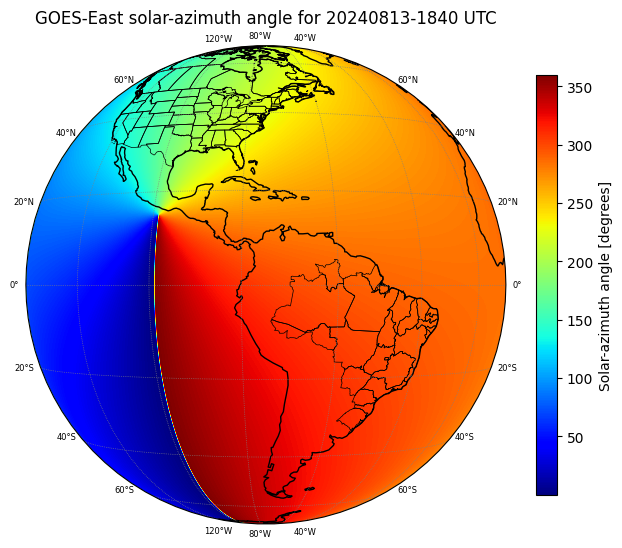

In [68]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0,0,1,1], projection=crs)
extent = [projx.min(), projx.max(), projy.min(), projy.max()]
im = ax.imshow(solaz, cmap='jet', extent=extent, transform=crs)
ax.coastlines()
ax.add_feature(state_borders, edgecolor="black", linewidth=0.5)
plt.title(f'GOES-East solar-azimuth angle for {abidt.strftime("%Y%m%d-%H%M UTC")}')

gl = ax.gridlines(
  crs=ccrs.PlateCarree(),
  draw_labels=True,
  linewidth=0.5,
  color="gray",
  linestyle=":",
)
# Customize the gridline labels
gl.xlocator = mticker.FixedLocator([-120, -100, -80, -60, -40, -20])
#gl.xformatter = LONGITUDE_FORMATTER
# only display given longitudes
gl.xformatter = plt.FuncFormatter(lambda x, pos: f'{np.abs(int(x))}°W' if x in [-120, -80, -40] else '')
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {"size": 6}
gl.ylabel_style = {"size": 6}

cbar = plt.colorbar(im, ax=ax, shrink=0.7)
cbar.set_label('Solar-azimuth angle [degrees]')

Solar-azimuth angle is a little more difficult to understand. Essentially, for an observer looking north, at what angle is the sun (moving clockwise)?

In the figure above, for an observer in western Oklahoma (say, 98 deg W), the sun is directly "behind" him/her (the sun is to the south of NH observers most of the time). Therefore, the solar-azimuth angle is 180 degrees.


In the animation below, the solar-azimuth angle is valid both during the daytime (when solar-zenith angle is ≤ 90 degrees) and nighttime. However, it really only makes sense when the sun is *above* the horizon. Therefore, any analysis involving solar-azimuth angle should also include the solar-zenith angle. For example, you may only want to use solar-azimuth angle when solar-zenith angle is ≤ 90 degrees.

This animation is for the vernal equinox. Therefore, the sun reaches the zenith position on the equator (blue bull's eye in solar-zenith angle).

<img src="https://github.com/jlc248/satellite-resources/blob/main/docs/_static/images/solar_angles.gif?raw=true">